<a href="https://colab.research.google.com/github/AHartNtkn/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS7_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

I want to see more machine learning! scikit-learn, even tensorflow and keras.

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
#From: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb

import numpy as np
import os
import sys
import tensorflow as tf

# Reset the tensorflow graph
def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

# %matplotlib nbagg # This line breaks things
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# This took some doing to fix. I suspect that this is the correct way to do animations with google collab. (1/2)
from matplotlib import rc 
rc('animation', html='jshtml')

# # Commented out, since I won't be doing any local saving
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "rl"
#   
# def save_fig(fig_id, tight_layout=True):
#   path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
#   print("Saving figure", fig_id)
#   if tight_layout:
#     plt.tight_layout()
#   plt.savefig(path, format='png', dpi=300)

In [0]:
import gym

# Get the Ms. Pacman Gym Environment
env = gym.make('MsPacman-v0')
obs = env.reset()

In [0]:
obs.shape

(210, 160, 3)

In [0]:
img = env.render(mode="rgb_array")

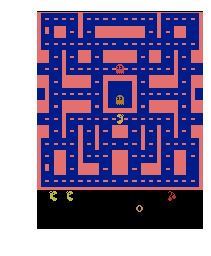

In [0]:
# Let's see what the environment looks like

# plt.figure(figsize=(5,4))
# plt.imshow(img)
# plt.axis("off")
# save_fig("MsPacman") # Commented out, because I don't want it to actually save.
# plt.show()

# Let's move this up here
def plot_environment(env, figsize=(5,4)):
  plt.close()
  plt.figure(figsize=figsize)
  img = env.render(mode="rgb_array")
  plt.imshow(img)
  plt.axis("off")
  plt.show()

plot_environment(env)

In [0]:
(img == obs).all()

True

In [0]:
env.action_space

Discrete(9)

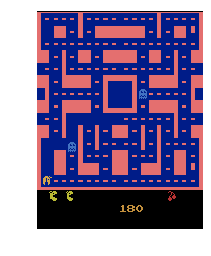

In [0]:
env.reset()
for step in range(110):
  env.step(3)
for step in range(40):
  env.step(8)
plot_environment(env)

Neat!

In [0]:
obs, reward, done, info = env.step(0)

In [0]:
obs.shape

(210, 160, 3)

In [0]:
reward

0.0

In [0]:
done

False

In [0]:
info

{'ale.lives': 3}

In [0]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
  img = env.render(mode = "rgb_array")
  frames.append(img)
  if step % n_change_steps == 0:
    action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  if done:
    break

In [0]:
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch, # Why is this comma here?

def plot_animation(frames, repeat = False, interval = 40):
  plt.close()
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat = repeat, interval=interval)

# This took some doing to fix. I suspect that this is the correct way to do animations with google collab. (2/2)
video = plot_animation(frames)
plt.close()
video

Great! Now that we can play, let's try to play well.

In [0]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]
    img = img.sum(axis=2)
    img[img==mspacman_color] = 0
    img = (img // 3 - 128).astype(np.int8)
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

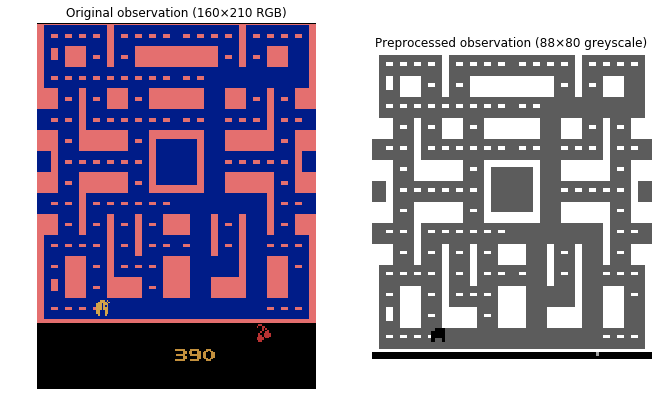

In [0]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
# save_fig("preprocessing_plot") # No saving locally!
plt.show()

In [0]:
reset_graph()

# Network input
input_height = 88 
input_width = 80
input_channels = 1 # Monocrome

# Convolution layer settup
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)] 
conv_strides = [4,2,1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3 

# Hidden layers
n_hidden_in = 64 * 11 * 10 
n_hidden = 512
hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n

initializer = tf.variance_scaling_initializer()

# Deep Q Network
def q_network(X_state, name):
  prev_layer = X_state / 180.0 # Scale to [-1, 1]
  # Construct network
  with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden, activation=hidden_activation, kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=initializer)
  trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
  trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
  return outputs, trainable_vars_by_name

In [0]:
# Default network without internals
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])

online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

# Whenever variables are trained online, they will be copied over to the network variables.
copy_ops = [target_var.assign(online_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [0]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [0]:
learning_rate = 0.001
momentum = 0.95

# Gradient decent w/ momentum
with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
# Learning from memories

class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]
      
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

def sample_memories(batch_size):
          # state, action, reward, next_state, continue
    cols = [[],    [],     [],     [],         []] 
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [0]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

# If it's confident in a move, then it will take that move, otherwise, ti will act randomly
def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return np.argmax(q_values)

In [0]:
n_steps = 4000000
training_start = 10000
training_interval = 4
save_steps = 1000 # save after 1000 steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90 # frames until game starts
batch_size = 50
iteration = 0
checkpoint_path = "./my_dqn.ckpt" # save here
done = True

In [0]:
# Progress tracking
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

with tf.Session() as sess:
  if os.path.isfile(checkpoint_path + ".index"):
    saver.restore(sess, checkpoint_path)
  else:
    init.run()
    copy_online_to_target.run()
  while True:
    step = global_step.eval()
    if step >= n_steps:
      break
    iteration += 1
    print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
      iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
    if done:
      obs = env.reset()
      for skip in range(skip_start): # skip the start of each game
        obs, reward, done, info = env.step(0)
      state = preprocess_observation(obs)

    q_values = online_q_values.eval(feed_dict={X_state: [state]})
    action = epsilon_greedy(q_values, step)

    obs, reward, done, info = env.step(action)
    next_state = preprocess_observation(obs)

    replay_memory.append((state, action, reward, next_state, 1.0 - done))
    state = next_state

    total_max_q += q_values.max()
    game_length += 1
    if done:
      mean_max_q = total_max_q / game_length
      total_max_q = 0.0
      game_length = 0

    if iteration < training_start or iteration % training_interval != 0:
      continue
    
    X_state_val, X_action_val, rewards, X_next_state_val, continues = (
      sample_memories(batch_size))
    next_q_values = target_q_values.eval(
      feed_dict={X_state: X_next_state_val})
    max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
    y_val = rewards + continues * discount_rate * max_next_q_values

    _, loss_val = sess.run([training_op, loss], feed_dict={
      X_state: X_state_val, X_action: X_action_val, y: y_val})

    if step % copy_steps == 0:
      copy_online_to_target.run()

    if step % save_steps == 0:
      saver.save(sess, checkpoint_path)

Iteration 6213	Training step 0/4000000 (0.0)%	Loss   inf	Mean Max-Q 0.056493   

KeyboardInterrupt: ignored

Well then... this is taking too long to train, so I'm going to stop here. Still, it was interesting seeing DQN's internals.

In [0]:
env.close()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




1.

I started out looking for a notebook for machine learning applications. I found one on reinforcement learning, playing Ms. Pacman through AI gym. It seemed pretty cool. I didn't get to any actual learning, but I did learn how to interact with an RL environment, and previewed some tensorflow functions.

I went through, cell by cell, typing in everything and thinking through what each line is doing. It mostly made sense, though a lot of the neural network archetecture stuff was a bit confounding, and I don't really understand how it's learning. I can see some of the broad strokes, but I suppose I just need to read up more on Q-learning, as well as some of the technicalities of tensorflow. 

2.

Getting animation to work. It was a rough debugging experience, but at least there was a nice solution in the end.

3.

Seeing the different parts of the environment through looking at `obs, reward, done, info = env.step(0)`. It really makes the whole scenario more concrete. If I understood more what the DQN was trying to do, I'd probably appreciate it more.

4.

Actually getting something that learns. Literally, It would take days to train in collab. Maybe if I had it running locally on a GPU.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.